In [8]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jul 19 16:44:55 2019

@author: Dylan
"""

#import all modules
from PIL import Image
import pandas as pd
import sys
from time import time

### for ROC curve metrics
from sklearn import metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dask import delayed

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from skimage.data import lfw_subset
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from numpy import asarray
# import Functions

# working directories
# --- change file path for you computer
# jeremy
# marijn
main = "/home/dylan/Projects/Tetse_proj/Dylan/"
data_2 = "/home/dylan/Projects/Tetse_proj/Dylan/2/"
data_2_thumb =  "/home/dylan/Projects/Tetse_proj/Dylan/2/thumbnail" 


# Create training data set
## 1) create training dataset of labeled coordinates for all sampled images

In [9]:

# Read in labeled data from text file and create indexable dataframe

df = pd.read_fwf(data_2 + 'refined_data.txt',header=None)
which = lambda lst:list(np.where(lst)[0])
new = df.iloc[:,4].str.split(" ", n = 23, expand = True)
df= df.drop(labels=4, axis=1)
result = pd.concat([df, new], axis=1, sort=False)
        # column numbers were messed up, make them go according to range
result.columns = range(result.shape[1])
result.reset_index(inplace=True, drop=True)

text_data = result.copy() 


In [10]:

# Create pixel sampling function for a single image

def pix_sample(image, imgname, i):

    coord_label_df = pd.DataFrame(columns=['label', 'coord', 'Image_name'])
    x1landmark = float(result.loc[i,15])
    y1landmark = float(result.loc[i,16])

    R= 9 ### with R 9 the second plot is quite hard to tell whether it works 
    Rmax= 300

    npospix = 100
    nnegpix = 2*npospix

    a = np.random.uniform(0,1,npospix) * 2 * np.pi
    r = R * np.sqrt(np.random.uniform(0,1,npospix))

    ## If you need it in Cartesian coordinates
    xwithin = r * np.cos(a)
    ywithin = r * np.sin(a)

    outer_radius =Rmax*Rmax
    inner_radius = R*R
    rho= np.sqrt(np.random.uniform(inner_radius, 
                             outer_radius, size=nnegpix))

    theta=  np.random.uniform( 0, 2*np.pi, nnegpix)
    xhoop = rho * np.cos(theta)
    yhoop = rho * np.sin(theta)

    for i in range(len(xwithin)):
        df2_within = pd.DataFrame({'label': ['pos'], 'coord': [(x1landmark + xwithin[i],y1landmark + ywithin[i])], 'Image_name':[imgname]})
        coord_label_df = coord_label_df.append(df2_within)
        #print(coord_label_df)
    for i in range(len(xhoop)):
        df2_hoop = pd.DataFrame({'label': ['neg'], 'coord': [(x1landmark + xhoop[i], y1landmark + yhoop[i])], 'Image_name': [imgname]})
        coord_label_df = coord_label_df.append(df2_hoop)
    return(coord_label_df)


In [5]:

# Create a function that generates a dataset of labaled coordinates
# using the pixel sampling function

def coord_Tset(text_data):
    df = pd.DataFrame(columns=['label', 'coord', 'Image_name'])
    for i in range(text_data.shape[0]):
        imgname=" ".join(result.loc[i,[0,1,2]])
#    file, ext = os.path.splitext(imgname)
        img = mpimg.imread(data_2 + imgname)
        df = df.append(pix_sample(img , imgname , i ))
    return(df)

Tset = coord_Tset(text_data)
print(Tset.head())



  label                                   coord                  Image_name
0   pos  (723.9749189827912, 708.7845733304831)  A002 - 20170126_195145.jpg
0   pos  (716.3523130025592, 702.7379432253284)  A002 - 20170126_195145.jpg
0   pos  (728.4164958063768, 700.6727771940558)  A002 - 20170126_195145.jpg
0   pos   (714.917447032789, 701.2334632455775)  A002 - 20170126_195145.jpg
0   pos    (729.401101565166, 696.032049206247)  A002 - 20170126_195145.jpg


# 2. Add Haarlike features for each pixel sample to the dataset 

723.9749189827912


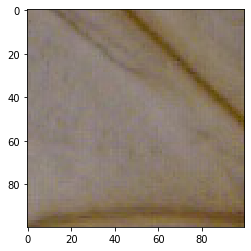

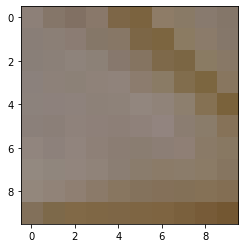

In [11]:


#EXAMPLE getting window

#from Tset get coordinates
line = Tset.iloc[[0]]
x,y = line.iloc[0,1]
print(x)

#open image
im = " ".join(result.loc[1,[0,1,2]])
im = Image.open(data_2 + im)

#crop image
img_cropped = im.crop((x-50,y-50,x+50,y+50))
plt.imshow(img_cropped)
plt.show()

# get thumbnail of image (reduce resolution)
img_cropped.thumbnail([10,10])

plt.imshow(img_cropped)



In [12]:
#turn image to grey scale for inegral_image() function in extract_feature_image()

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray


In [40]:
def get_window(PIL_image, line , CropX=50, CropY=50, thumbnail=20):
    x,y = line.iloc[0,1]
    PIL_image.crop((x- CropX,y-CropY,x+CropX,y+CropY) )
    PIL_image.thumbnail([20,20])
    return PIL_image

feature_types = ['type-4', 'type-2-x', 'type-2-y','type-3-x', 'type-3-y']

def extract_feature_image(img, feature_types, feature_coord=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    features = []
    for i in range(len(feature_types)):
        features.extend(haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_types[i],
                             feature_coord=None))
    return features



In [15]:
#EXAMPLE getting features from window

z = extract_feature_image(rgb2gray(asarray(img_cropped)), feature_types)


In [ ]:
# The Function below extracts haarlike features from a window around each pixel sample
# and appends it to the the dataframe.

# INPUT: The coordinate dataset generated from coord_Tset

def features_Tset(Tset):
    df_final = pd.DataFrame([])
    for i in range(len(Tset)):
        line = Tset.iloc[[i]]
        imgname = line.iloc[0,2]
        img = Image.open(data_2 + imgname)
        window = get_window(img, line)
        features = extract_feature_image(rgb2gray(asarray(window)), feature_types)
        df_final.append(line.join(pd.DataFrame(features)))
    return  df_final

v = features_Tset(Tset)
        
